In [1]:
#pip install cvxpy[GLPK,SCIP]

In [2]:
from cvxpy import *

print(installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


# Mixed integer programming for multi-vehicle path planning

By Schouwenaars et al.

10.23919/ECC.2001.7076321  
https://ieeexplore.ieee.org/document/7076321/

## **Plotting**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams.update({'font.size': 8})


def plot(T=None, C=None, F=None, S=None, s0=None, sf=None):
    '''
    S : 2-dimensional array (4, n)

    S[0,:] --> x
    S[1,:] --> xdot
    S[2,:] --> y
    S[3,:] --> ydot
    '''
    fig = plt.figure(figsize=(5, 6));
    ax = fig.subplots(3, 1, height_ratios=[3,1,1]);

    if S is not None and T is not None:
        V = np.sqrt(S[1,:]**2 + S[3,:]**2)
        FF = np.sqrt(F[0,:]**2 + F[1,:]**2)

        ax[0].plot(S[0,:], S[2,:], '.-r');

        ax[1].plot(T, V, '.-r', label='$|v|$');
        ax[1].plot(T, S[1,:], '.-g', label='$v_x$');
        ax[1].plot(T, S[3,:], '.-b', label='$v_y$');
        ax[1].legend()

        ax[2].plot(T[0:-1], FF, '.-r', label='$|f|$');
        ax[2].plot(T[0:-1], F[0,:], '.-g', label='$f_x$');
        ax[2].plot(T[0:-1], F[1,:], '.-b', label='$f_y$');
        ax[2].legend()
    
    if s0 is not None:
        ax[0].plot(s0[0], s0[2], 'ob', markersize=10);

    if sf is not None:
        sf = np.reshape(sf,(-1,4))
        ax[0].plot(sf[:,0], sf[:,2], 'dg', markersize=8);

    if C is not None:
        RECTS = []
        for k in range(len(C)):
            RECTS.append(patches.Rectangle((C[k,0], C[k,2]),
                                        np.abs(C[k,0]-C[k,1]),
                                        np.abs(C[k,2]-C[k,3]),
                                        linewidth=1, edgecolor='k', facecolor='k')
        )

        for k in range(len(RECTS)):
            ax[0].add_patch(RECTS[k])

    ax[0].set_aspect('equal');
    ax[0].axis('equal');
    ax[0].set_xlabel('$x$');
    ax[0].set_ylabel('$y$');

    ax[1].set_xlabel('Time (s)');
    ax[1].set_ylabel('$|v|$');

    ax[2].set_xlabel('Time (s)');
    ax[2].set_ylabel('$|f|$');

    plt.tight_layout()


def plot_turn_rate(T, S, F, m):
    w = np.zeros(len(T))
    v = S[1::2, :]
    for k in range(len(T)):
        w[k] = np.rad2deg(np.linalg.norm(F[:,k]) / (m * np.linalg.norm(v[:,k])))

    fig = plt.figure(figsize=(5, 2));
    ax = fig.subplots();
    ax.plot(T, w, '.-r')
    ax.grid();
    ax.set_xlabel('Time (s)');
    ax.set_ylabel('Turn rate (deg/s)');

    plt.tight_layout()

## **The environment**

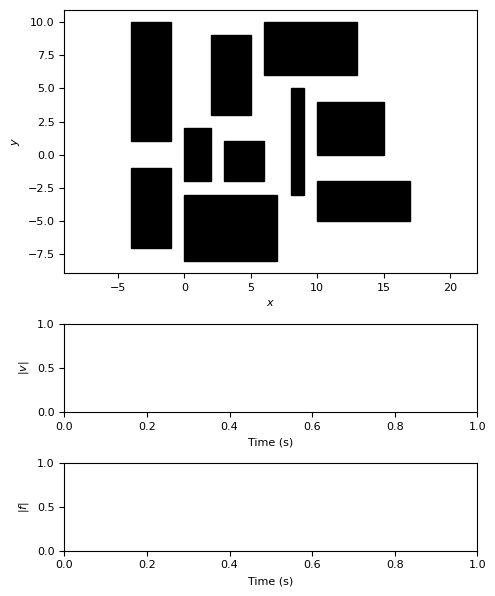

In [4]:
import numpy as np


C = np.array([[-4,-1, -7, -1],
            [0, 7, -8, -3],
            [-4, -1, 1, 10],
            [0, 2, -2, 2],
            [3, 6, -2, 1],
            [2, 5, 3, 9],
            [6, 13, 6,    10],
            [8, 9, -3, 5],
            [10, 17, -5, -2],
            [10, 15, 0, 4]], dtype=np.float32)
L = len(C)

plot(C=C)

## System model

The vehicle is modeled as a simple 2-D discrete double integrator with discretization step $m=1$, $b=0$, and $dt=0.1$.

$$
\begin{bmatrix}
x_{i+1}\\
v_{x_{i+1}}\\
y_{i+1}\\
v_{y}{}_{_{i+1}}
\end{bmatrix} =\begin{bmatrix}
1 & \Delta t & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & \Delta t\\
0 & 0 & 0 & 1
\end{bmatrix}\begin{bmatrix}
x_{i}\\
v_{x_{i}}\\
y_{i}\\
v_{y_{i}}
\end{bmatrix} +\frac{1}{m}\begin{bmatrix}
0.5\Delta t^{2} & 0\\
\Delta t & 0\\
0 & 0.5\Delta t^{2}\\
0 & \Delta t
\end{bmatrix}\begin{bmatrix}
u_{x}\\
u_{y}
\end{bmatrix}
$$

In [ ]:
import numpy as np
from scipy import sparse

m    = 1.
b    = 0.
dt   = 0.1 #10 Hz
mass = 1.0

Ad   = np.array([[1.,   dt,  0., 0. ],    # x
                 [0.,   1,   0., 0. ],    # xdot
                 [0.,   0.,  1., dt ],    # y
                 [0.,   0.,  0., 1, ]])   # ydot
Bd   = 1.0 / mass * np.array([[0.5*dt**2, 0.        ],
                              [dt,        0.        ],
                              [0.,        0.5*dt**2 ],
                              [0.,        dt        ]])

[ns, nu] = Bd.shape

# Bounds, the values are not mentioned in the paper!
vmin = 2.0

## Fuel-optimal path with fixed-arrival time

As written in Section 6.2, the final state can be constrained instead of including it in the cost function.  
The cost function is Eq. (25).

This section is very brief. To generate Fig. 1, it is only possible if we limit the minimum velocity. Since the final time is fixed, the vehicle can decide to simply not move if the minimium velocity is not set.

In [ ]:
from cvxpy import *

# Initial and reference states, mentioned in Section 6.3
s0 = np.array([ 15., 0.,  8., 0.])
sf = np.array([-0.5, 0., -5., 0.])

# Prediction horizon
tf = 8
N = np.int32(tf/dt)

# Define problem
u  = Variable((nu, N))
s  = Variable((ns, N+1))
t1 = Variable((4*L, N), boolean=True)
t2 = Variable((4*L, N), boolean=True)
t3 = Variable((4*L, N), boolean=True)
t4 = Variable((4*L, N), boolean=True)

M = 20 # the big M notation, for the obstacles
r = np.array([1., 1.]) # input weighting vector

J = 0.
constraints  = [s[:,0] == s0] # initial
constraints += [s[:,N] == sf] # terminal

D = 8 # number of the polygon sides, for velocity bounds
b = Variable((D,N), boolean=True)

for k in range(1,N):
    for d in range(D):
        # maximum velocity:
        #constraints += [(s[1,k]*np.sin(2*np.pi*(d+1)/D) + s[3,k]*np.cos(2*np.pi*(d+1)/D)) <= vmax]
        # minimum velocity:
        constraints += [(s[1,k]*np.sin(2*np.pi*(d+1)/D) + s[3,k]*np.cos(2*np.pi*(d+1)/D)) >= vmin*np.cos(np.pi/M)-b[d,k]*M] 
    constraints += [sum(b[:,k]) <= D-1]

for k in range(N):
    # Eq (7)
    constraints += [s[:,k+1] == Ad@s[:,k] + Bd@u[:,k]]

    # Eq (11), obstacles
    for l in range(L):
        constraints += [s[0,k]  <=  C[l, 0] + M*t1[l,k],
                        -s[0,k] <= -C[l, 1] + M*t2[l,k],
                        s[2,k]  <=  C[l, 2] + M*t3[l,k],
                        -s[2,k] <= -C[l, 3] + M*t4[l,k]]
        constraints += [t1[l,k] + t2[l,k] + t3[l,k] + t4[l,k] <= 3]

J += norm1(u)/N # fuel optimal: minimizing u
prob = Problem(Minimize(J), constraints)

res = prob.solve(solver=GUROBI, verbose=True)
if res == np.inf:
    print('no solution found')

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Dec 01 10:44:05 AM: Your problem has 13924 variables, 5039 constraints, and 0 parameters.
(CVXPY) Dec 01 10:44:06 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 01 10:44:06 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 01 10:44:06 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 01 10:44:06 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 01 10:44:06 AM: Compiling problem (target solver=GUROB

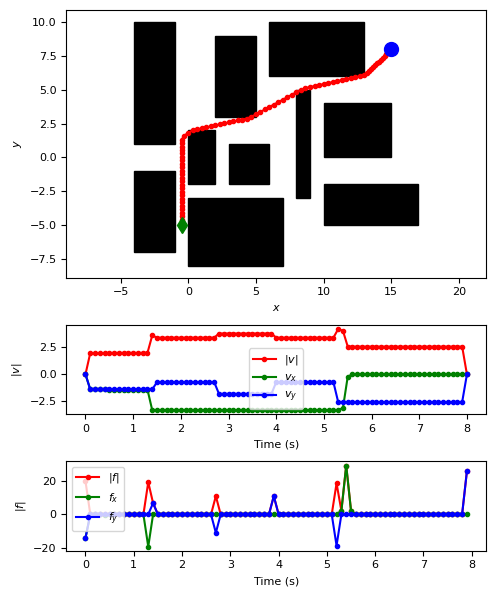

In [10]:
time_span = np.linspace(0, tf, N+1)
plot(C=C, T=time_span, F=u.value, S=s.value, s0=s0, sf=sf)

## Receding Horizon

In [101]:
from cvxpy import *
import numpy as np

umax = 5

# Initial and reference states, mentioned in Section 6.3
s0 = np.array([ 15., 0.,  8., 0.])
sf = np.array([-0.5, 0., -5., 0.])

# Prediction horizon
th = 3.0
N = np.int32(th/dt)

# Define problem
u = Variable((nu, N))
v = Variable((nu, N)) # slack variable for abs(u)
s = Variable((ns, N+1))
w = Variable((ns, N+1)) # slack variable for abs(state errors)
t = Variable((4*L, N), integer=True)

# Use parameter to easily change the intial state
s_init = Parameter(ns)


M = 20 # the big M notation
r = np.array([1., 1.]) # input weighting vector
q = np.array([10., 0., 10, 0.]) # state weighting vector
p = np.array([10., 2., 10, 2.]) # terminal state weighting vector

# Terminal constraints
constraints  = [s[:,0] == s_init]
J  = p@w[:,N]
constraints += [(s[:,N]-sf) <= w[:,N], -(s[:,N]-sf) <= w[:,N]]

# Stage constraints
for k in range(N):
    # Eq (7)
    J += r@v[:,k]
    J += q@w[:,k]

    constraints += [u[:,k] <= v[:,k], -u[:,k] <= v[:,k]]
    constraints += [(s[:,k]-sf) <= w[:,k], -(s[:,k]-sf) <= w[:,k]]

    constraints += [v[:,k] <= umax]

    constraints += [s[:,k+1] == Ad@s[:,k] + Bd@u[:,k]]

    # Eq (11)
    for l in range(L):
        constraints += [s[0,k]  <=  C[l, 0] + M*t[0+4*l,k],
                        -s[0,k] <= -C[l, 1] + M*t[1+4*l,k],
                        s[2,k]  <=  C[l, 2] + M*t[2+4*l,k],
                        -s[2,k] <= -C[l, 3] + M*t[3+4*l,k]]
        constraints += [t[0+4*l,k] + t[1+4*l,k] + t[2+4*l,k] + t[3+4*l,k] <= 3]
    constraints += [t[:,k] >= 0, t[:,k] <= 1]

prob = Problem(Minimize(J), constraints)


S = []
U = []
T = []
S.append(s0)
k = np.int32(0)

while(True):
    T.append(k*dt)
    s_init.value = s0
    prob.solve(solver=GUROBI)
    s0 = Ad@s0 + Bd@u[:,0].value
    S.append(s0)
    U.append(u[:,0].value)

    d = np.linalg.norm(s0[::2]-sf[::2])
    print("Step #", k)
    print ("Distance to destination: ", d)

    if  d < 0.01:
        break

    k = k + 1

T.append(k*dt)
S = np.array(S)
U = np.array(U)
T = np.array(T)


Step # 0
Distance to destination:  20.1958353842695
Step # 1
Distance to destination:  20.09243394456253
Step # 2
Distance to destination:  19.918607793183853
Step # 3
Distance to destination:  19.674373899105365
Step # 4
Distance to destination:  19.359756588681826
Step # 5
Distance to destination:  18.97478892160268
Step # 6
Distance to destination:  18.53542012763555
Step # 7
Distance to destination:  18.05751150867172
Step # 8
Distance to destination:  17.55706766518823
Step # 9
Distance to destination:  17.050725829054198
Step # 10
Distance to destination:  16.540184957418205
Step # 11
Distance to destination:  16.011613567381016
Step # 12
Distance to destination:  15.45094319972873
Step # 13
Distance to destination:  14.860819838184351
Step # 14
Distance to destination:  14.232701522473983
Step # 15
Distance to destination:  13.561471681097073
Step # 16
Distance to destination:  12.858597774116202
Step # 17
Distance to destination:  12.145380923535406
Step # 18
Distance to destin

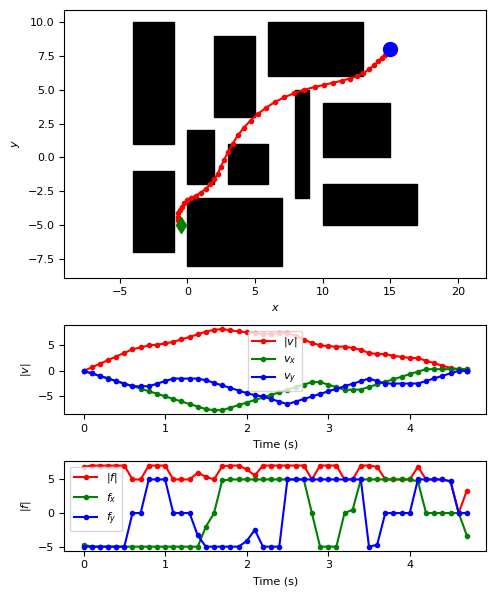

In [102]:
plot(C=C, T=T, F=U.transpose(), S=S.transpose(), s0=S[0,:], sf=S[-1,:])

## Fuel-optimal and shortest-time path

This topic is not mentioned in the paper. However, we can find it in in the follow in Richard's Master thesis, page 75.

Richards, A. G. (2002). Trajectory Optimization using Mixed-Integer Linear Programming [MASSACHUSETTS INSTITUTE OF TECHNOLOGY]. https://www.mit.edu/people/jhow/Richards_SM.pdf

In this scenario, we need to apply maximum allowable input $(u_{\text{max}}=5)$ to avoid vehicle teleportation. 

In [70]:
from cvxpy import *

# maximum force
umax = 5.0

# Initial and reference states, mentioned in Section 6.3
s0 = np.array([ 15., 0.,  8., 0.])
sf = np.array([-0.5, 0., -5., 0.])

# Prediction horizon
tf = 10
N = np.int32(tf/dt)

# Define problem
u = Variable((nu, N))
v = Variable((nu, N)) # slack variable for abs(u)
s = Variable((ns, N+1))
t = Variable((4*L, N), integer=True)
b = Variable((N), integer=True)

M = 50 # the big M notation
r = np.array([1., 1.]) # input weighting vector

epsilon = 0.1

J = 0.
constraints  = [s[:,0] == s0]
constraints += [s[:,N] == sf]

for k in range(N):
    # Eq (7)
    J += k*b[k]
    constraints += [u[:,k] <= v[:,k], -u[:,k] <= v[:,k]]
    constraints += [s[:,k+1] == Ad@s[:,k] + Bd@u[:,k]]

    constraints += [v[:,k] <= umax]

    # Eq (11)
    for l in range(L):
        constraints += [s[0,k]  <=  C[l, 0] + M*t[0+4*l,k],
                        -s[0,k] <= -C[l, 1] + M*t[1+4*l,k],
                        s[2,k]  <=  C[l, 2] + M*t[2+4*l,k],
                        -s[2,k] <= -C[l, 3] + M*t[3+4*l,k]]
        constraints += [t[0+4*l,k] + t[1+4*l,k] + t[2+4*l,k] + t[3+4*l,k] <= 3]
    constraints += [t[:,k] >= 0, t[:,k] <= 1]

    # Minimum-time constraints
    constraints += [(s[0,k]-s[0,N]) <=  M*(1-b[k]),
                    (s[0,k]-s[0,N]) >= -M*(1-b[k]),
                    (s[2,k]-s[2,N]) <=  M*(1-b[k]),
                    (s[2,k]-s[2,N]) >= -M*(1-b[k])]

constraints += [sum(b) <= 1, sum(b) >= 1]

J += epsilon*sum(v[:,0:N-1])

prob = Problem(Minimize(J), constraints)

res = prob.solve(solver=GUROBI, verbose=True)
if np.isnan(res):
    print('no solution found')

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Dec 01 05:38:14 PM: Your problem has 4904 variables, 14410 constraints, and 0 parameters.
(CVXPY) Dec 01 05:38:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 01 05:38:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 01 05:38:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 01 05:38:15 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 01 05:38:16 PM: Compiling problem (target solver=GUROB

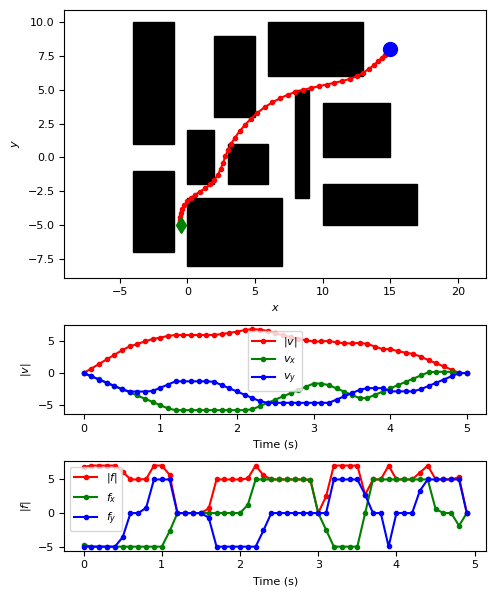

In [69]:
time_span = np.linspace(0, tf, N+1)
plot(C=C, T=time_span, F=u.value, S=s.value, s0=s0, sf=sf)

# Remarks

- There are incursions (cut corners) that intersect the real obstacle.

- This is a common issue due to the discrete time steps. However, the cut corners were not shown or mentioned in the paper.

- We can enlarge the obstacles or reduce the sampling-step length.